# Training Dense Autoencoders

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from time import time
import mplcyberpunk as cp
%matplotlib inline
plt.style.use('../dark-custom.mplstyle')

In [2]:
import sys
sys.path.append('..')
from ModelClasses.Autoencoders import DenseAutoencoder, DenseEncoder

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Training the Autoencoder
Let's compare one hidden layer and their different sizes

In [4]:
DATA_PATH = '../Datasets/data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])
mnist_train = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
mnist_test[0][0].shape

torch.Size([1, 28, 28])

In [5]:
INPUT_SHAPE = [1, 28, 28]
LEARNING_RATE = 0.002
BATCH_SIZE = 512
NUM_EPOCHS = 25
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

hidden_layers_list = [[6], [16], [64], [512], [1024], [4092]]
latent_space_dim = 2

In [6]:
def autoencoder_train_loop(model, dataloader, criterion,
                           optimizer, device, epochs):
    loss_list = []
    model.train()
    with tqdm(range(epochs)) as pbar:
        for _ in pbar:
            loss_train = 0
            for images, _ in dataloader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                loss_train += (loss_value := loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=loss_value)
            loss_list.append(loss_train / len(dataloader))
    return loss_list

In [7]:
loss_results = {}
trained_models = {}
model_path = './models/9.1-DenseAutoencoders/'
for hidden_layers in hidden_layers_list:
    architecture = hidden_layers + [latent_space_dim]
    print(f'{architecture}:')
    model_title = f'Architecture{architecture}'
    model_path_file = model_path + model_title
    
    autoencoder = DenseAutoencoder(
        input_shape=INPUT_SHAPE,
        encoder_hidden_layers=hidden_layers,
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder
    # torch.save(obj=autoencoder.state_dict(), f=f'{model_path_file}.pth')

[6, 2]:


100%|██████████| 25/25 [04:13<00:00, 10.16s/it, loss=0.691]


[16, 2]:


100%|██████████| 25/25 [04:13<00:00, 10.15s/it, loss=0.677]


[64, 2]:


100%|██████████| 25/25 [04:16<00:00, 10.25s/it, loss=0.674]


[512, 2]:


100%|██████████| 25/25 [04:22<00:00, 10.48s/it, loss=0.622]


[1024, 2]:


100%|██████████| 25/25 [04:26<00:00, 10.66s/it, loss=0.647]


[4092, 2]:


100%|██████████| 25/25 [04:25<00:00, 10.60s/it, loss=0.64] 


In [8]:
def plot_loss(epochs, loss_dict, config_dict, ax=None, colors=None, title=None):
    if loss_dict:
        if ax is None:
            ax = plt.gca()
        if colors is None:
            colors = [None] * (len(loss_dict))
        x_axis = range(1, epochs + 1)
        for (loss_type, loss), color in zip(loss_dict.items(), colors):
            ax.plot(x_axis, loss, label=f'{loss_type}: {min(loss):.3f}', color=color)
        ax.set(title=title, xlabel='Epoch', ylabel='Loss', **config_dict)
        ax.legend()

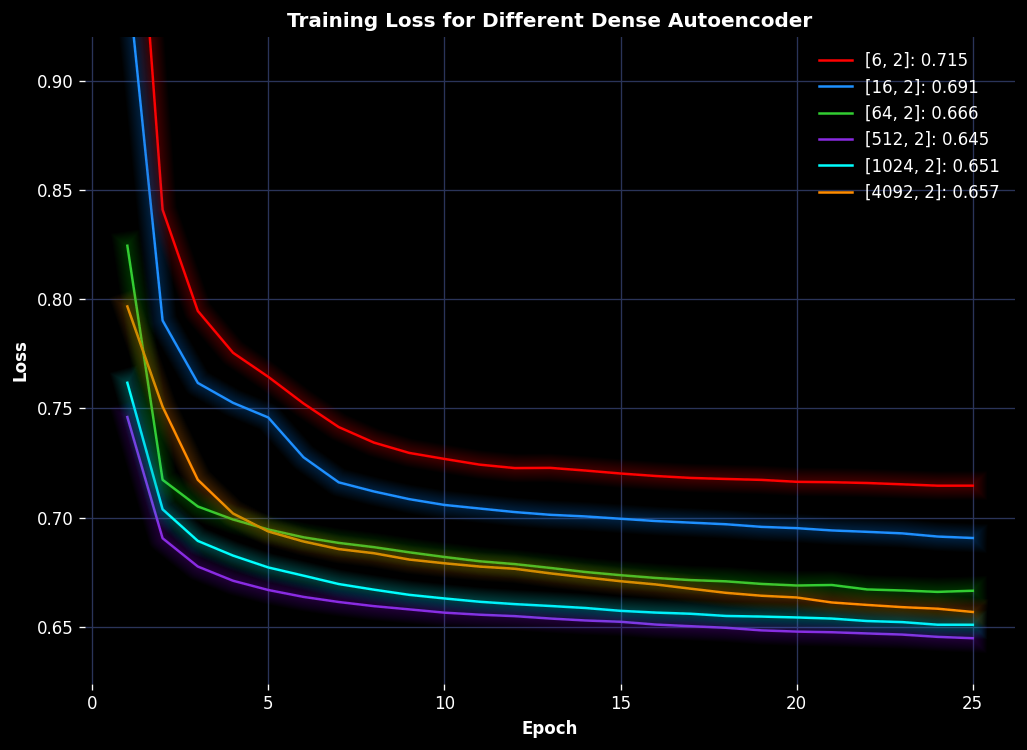

In [9]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.624, 0.92])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=loss_results,
          config_dict=config,
          title=f'Training Loss for Different Dense Autoencoder',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.1_image_1.png');

Let's try to reconstruct the images with trained model

In [10]:
def sample_random_digits(mnist_dataset, seed=42):
    torch.manual_seed(seed)
    targets = mnist_dataset.targets.numpy()
    samples = {}
    for digit in range(10):
        indices = [i for i, label in enumerate(targets) if label == digit]
        chosen_idx = np.random.choice(indices)
        samples[digit] = mnist_dataset[chosen_idx][0]
    return samples

def compare_generated_to_original_mnist(model_dict, mnist_dataset, cmap='gray'):
    n_rows = len(model_dict) + 1
    figure, axes = plt.subplots(n_rows, 10, figsize=(15, 2 * n_rows))
    image_dict = sample_random_digits(mnist_dataset, seed=42)
    for digit, img in image_dict.items():
        axes[0, digit].imshow(img.permute(1, 2, 0).numpy(), cmap=cmap)
        for i, model in enumerate(model_dict.values(), start=1):
            model.eval()
            reconstruction = model.cpu()(img.unsqueeze(0)).squeeze(0).detach()
            axes[i, digit].imshow(reconstruction.permute(1, 2, 0).numpy(), cmap=cmap)
    for ax in axes.ravel():
        ax.axis(False)
    for i, model_name in enumerate(['Original'] + list(model_dict.keys())):
        pos = axes[i, 0].get_position()
        x_coord = pos.y1 + (pos.y1 - pos.y0) / 5
        figure.text(0.5, x_coord, f'Architecture: {model_name}', 
                    ha='center', va='center', fontsize=18)
    return figure, axes

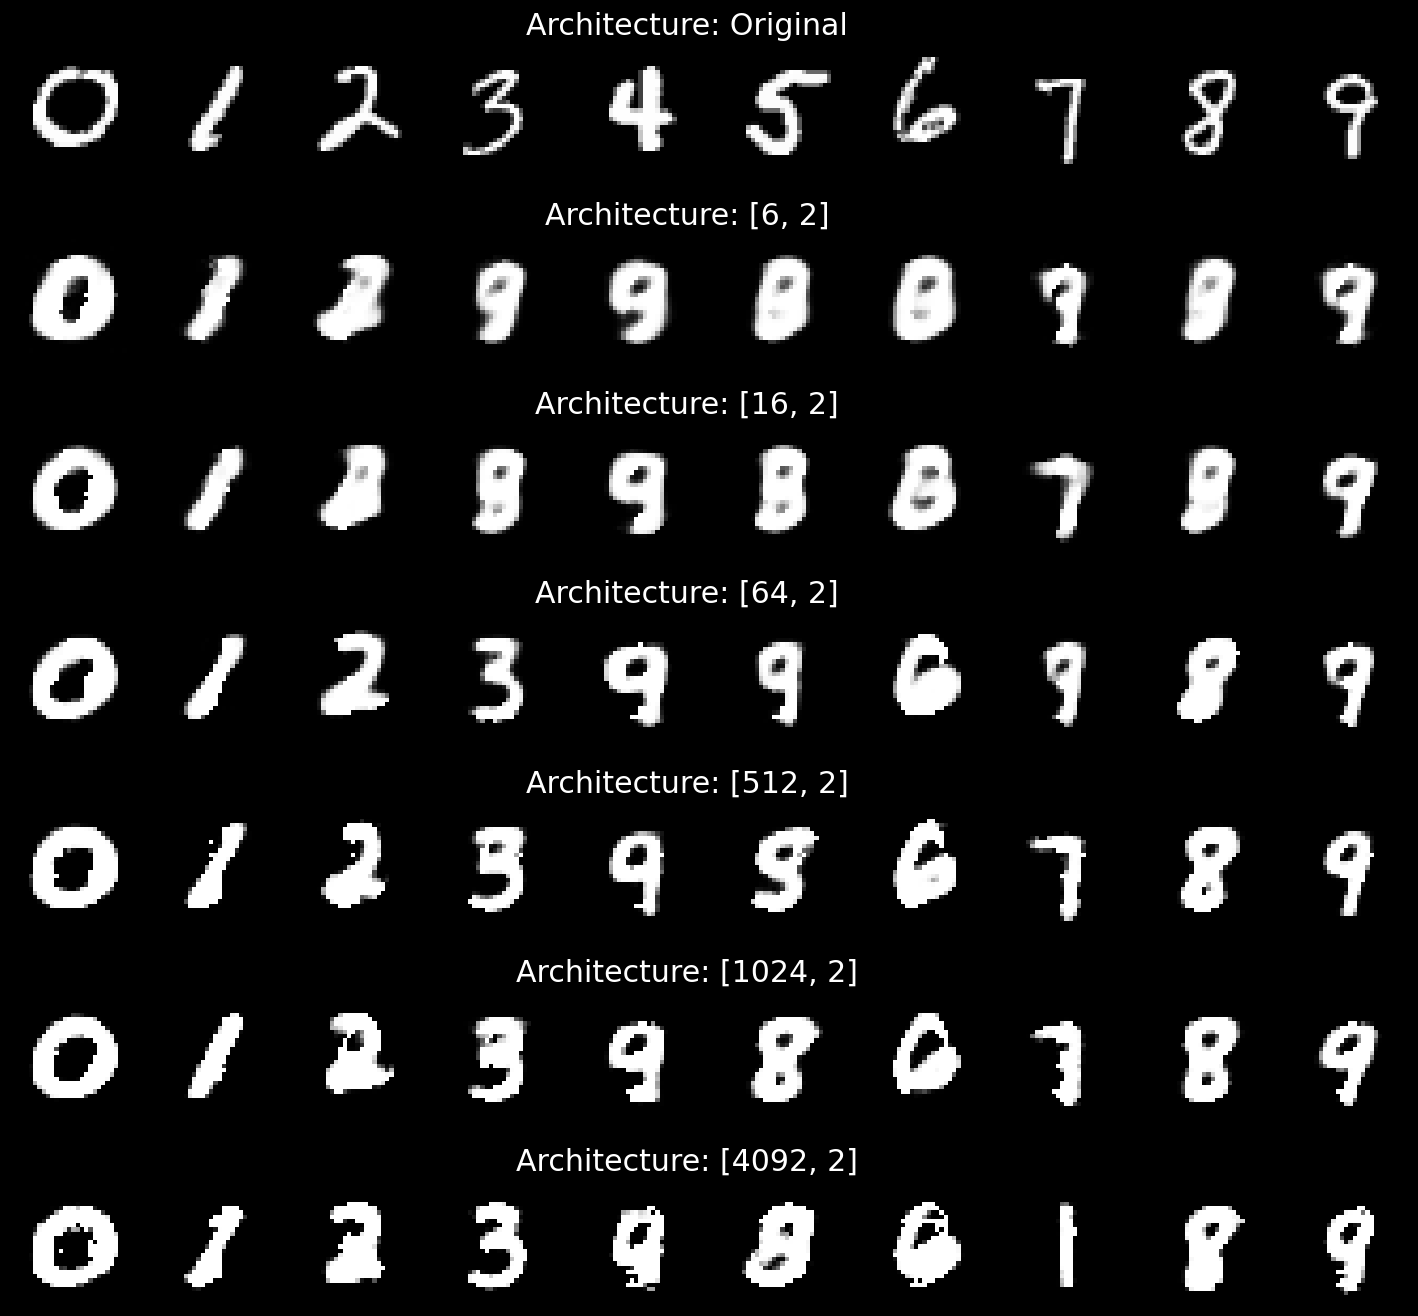

In [11]:
figure, _ = compare_generated_to_original_mnist(trained_models, mnist_test)
figure.savefig('./images/9.1_image_2.png');

We can see that networks with more parameters stop confusing 7 with 9 for example

In [12]:
def get_latent_space_points(encoder, dataset, batch_size=256, device='cuda'):
    encoder = encoder.to(device).eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    points_list = []
    label_list = []
    with torch.inference_mode():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            points = encoder(images).cpu().numpy()
            points_list.append(points)
            label_list.append(labels.numpy())
    return np.vstack(points_list).T, np.hstack(label_list)

In [13]:
arch = [1024, 2]
(points_dummy_x, points_dummy_y), labels_dummy = (
    get_latent_space_points(DenseEncoder(INPUT_SHAPE, hidden_layers=[1024]), mnist_test))
(points_trained_x, points_trained_y), labels_trained = get_latent_space_points(
    trained_models[f'{arch}'].encoder, mnist_test)

100%|██████████| 40/40 [00:01<00:00, 26.24it/s]


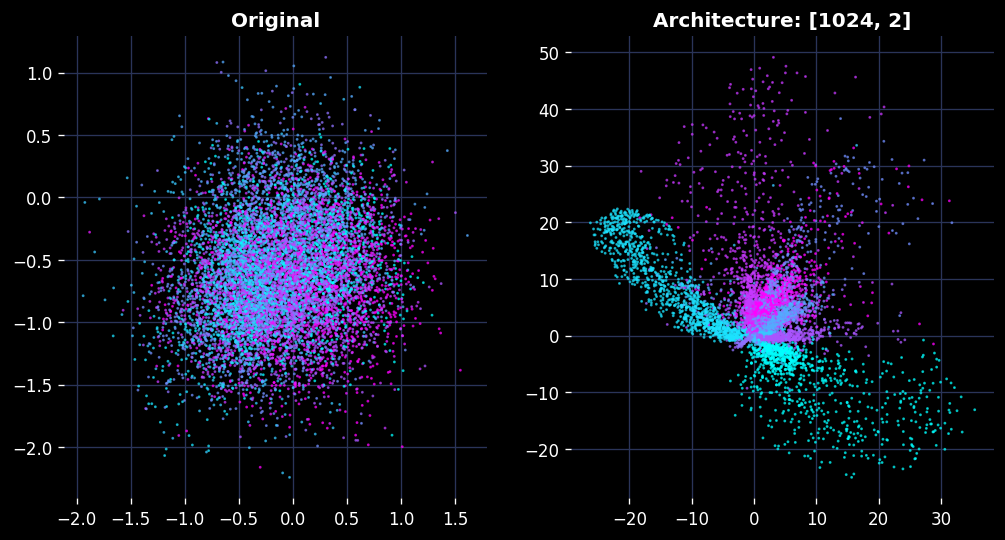

In [14]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(points_dummy_x, points_dummy_y, c=labels_dummy, s=0.5, alpha=0.7)
axes[1].scatter(points_trained_x, points_trained_y, c=labels_trained, s=0.5, alpha=0.7)
for ax, title in zip(axes.ravel(), ['Original', f'Architecture: {arch}']):
    ax.set(title=title)
figure.savefig('./images/9.1_image_3.png');

Let's now compare latent spaces for all trained models

In [15]:
def get_dict_of_latent_spaces(autoencoder_dict, dataset, batch_size=256, device='cuda'):
    latent_space_dict = {}
    for name, model in autoencoder_dict.items():
        latent_space_dict[name] = get_latent_space_points(
            model.encoder, dataset, batch_size=batch_size, device=device)
    return latent_space_dict

def compare_latent_spaces(latent_space_dict, axes_list,
                          s=0.5, alpha=0.7, cmap='cool'):
    for (name, space), ax in zip(latent_space_dict.items(), axes_list.ravel()):
        latent_points, labels = space
        ax.scatter(*latent_points, c=labels, s=s, alpha=alpha, cmap=cmap)
        ax.axis(False)
        ax.set(title=name)

100%|██████████| 40/40 [00:01<00:00, 22.52it/s]


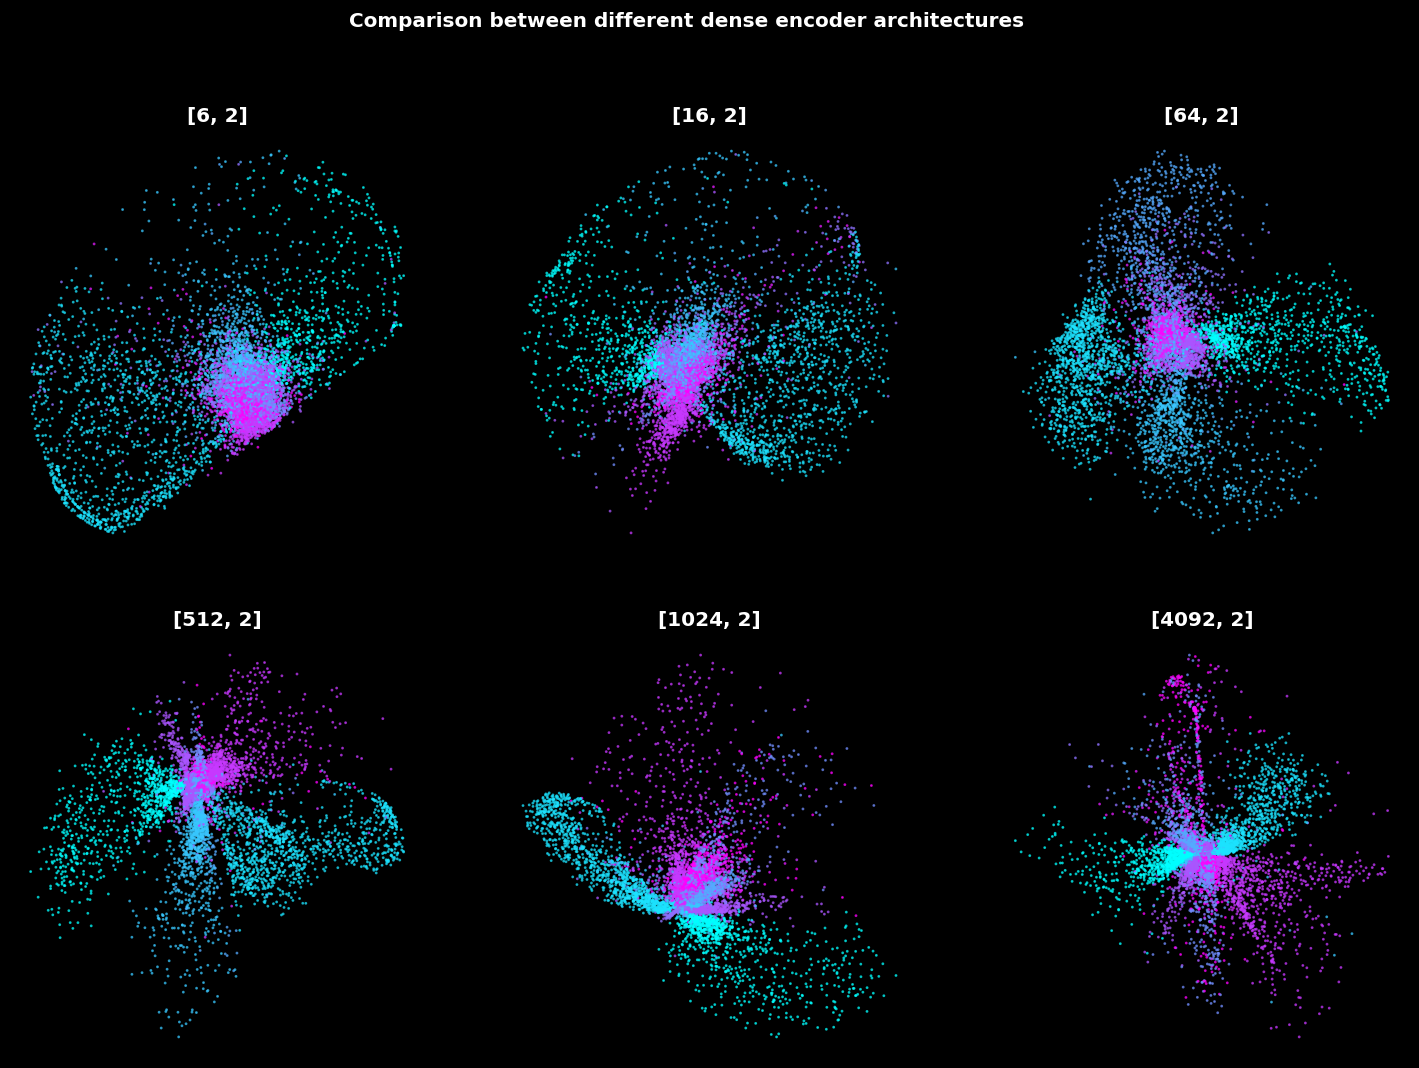

In [16]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
latent_space_dict = get_dict_of_latent_spaces(trained_models, mnist_test)
compare_latent_spaces(latent_space_dict, axes)
figure.suptitle(f'Comparison between different dense encoder architectures')
figure.savefig('./images/9.1_image_4.png');

Now Let's see if adding a third latent space dimension will improve performance

In [17]:
hidden_layers = [1024]
latent_space_dim = 3
architecture = hidden_layers + [latent_space_dim]
model_path_file = model_path + f'Architecture{architecture}'
autoencoder = DenseAutoencoder(
    input_shape=INPUT_SHAPE,
    encoder_hidden_layers=hidden_layers,
    latent_space_dimension=latent_space_dim
).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
)
trained_models[f'{architecture}'] = autoencoder
# torch.save(obj=autoencoder.state_dict(), f=f'{model_path_file}.pth')

100%|██████████| 25/25 [04:27<00:00, 10.72s/it, loss=0.601]


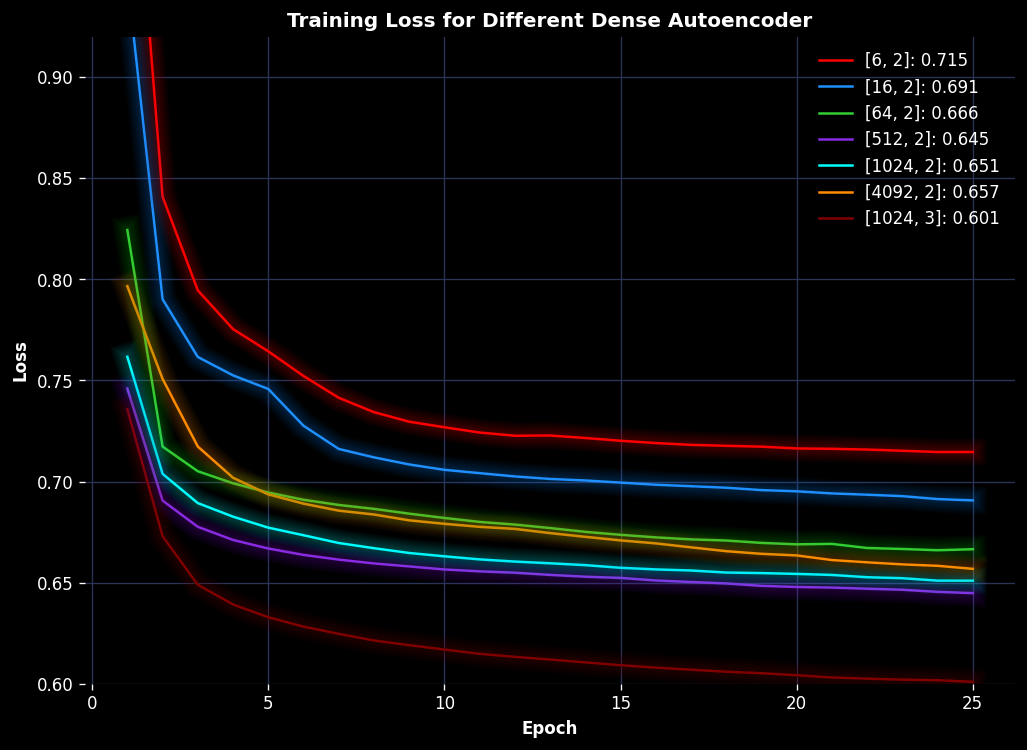

In [18]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.6, 0.92])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=loss_results,
          config_dict=config,
          title=f'Training Loss for Different Dense Autoencoder',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.1_image_5.png');

We can see that adding just one more dimension massively reduces the loss

In [19]:
def zoom_limits(data, zoom_factor):
    data_min, data_max = np.min(data), np.max(data)
    range_center = (data_max + data_min) / 2
    range_half = (data_max - data_min) * zoom_factor / 2
    return range_center - range_half, range_center + range_half

100%|██████████| 40/40 [00:01<00:00, 27.05it/s]


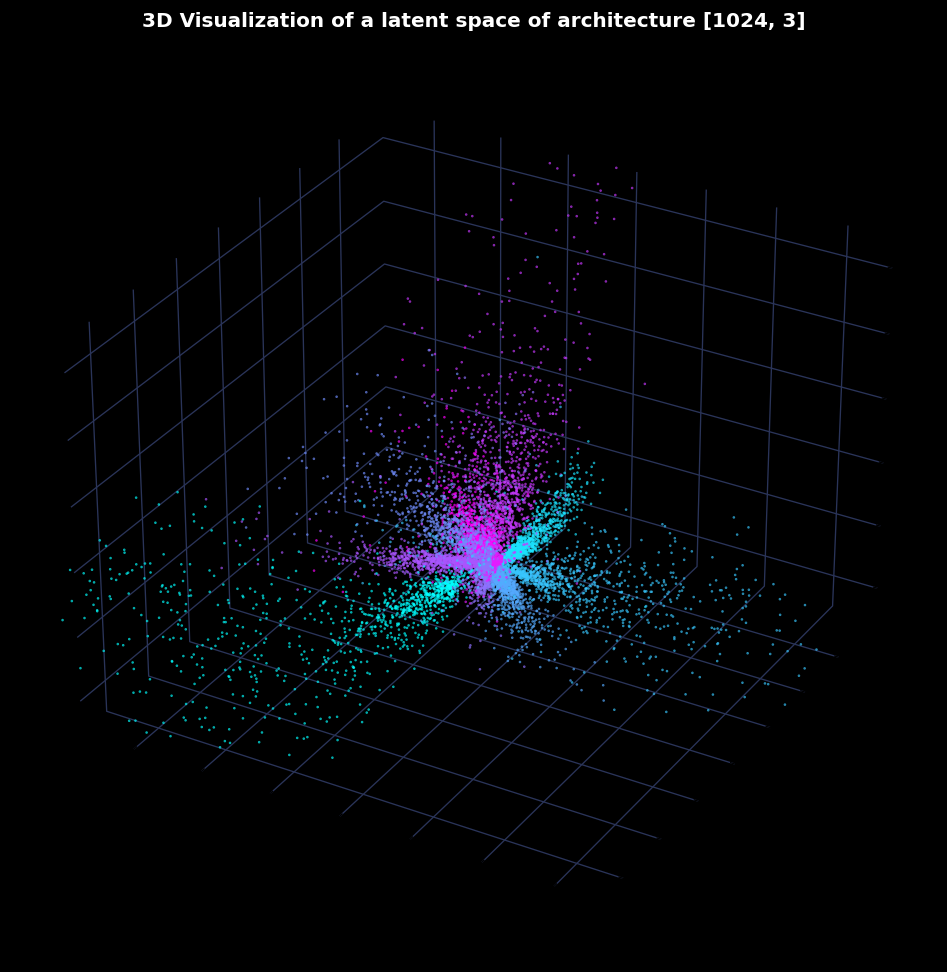

In [20]:
zoom = 0.8
figure, axes = plt.subplots(1, 1, subplot_kw=dict(projection='3d'), figsize=(10, 10))
space_points, labels = get_latent_space_points(
    trained_models[f'{architecture}'].encoder, mnist_test)
axes.scatter(*space_points, c=labels, s=0.3, alpha=0.7)
axes.set(title=f'3D Visualization of a latent space of architecture {architecture}')
for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis.set_tick_params(which='major', color='black')
axes.set_xticklabels([])
axes.set_yticklabels([])
axes.set_zticklabels([])
axes.set_xlim(zoom_limits(space_points[0], zoom_factor=zoom))
axes.set_ylim(zoom_limits(space_points[1], zoom_factor=zoom))
axes.set_zlim(zoom_limits(space_points[2], zoom_factor=zoom))
figure.savefig('./images/9.1_image_6.png');

In [21]:
hidden_layers = [1024]
latent_space_dim_list = [4, 16, 32, 64]
for latent_space_dim in latent_space_dim_list:
    architecture = hidden_layers + [latent_space_dim]
    print(f'{architecture}:')
    model_path_file = model_path + f'Architecture{architecture}'
    
    autoencoder = DenseAutoencoder(
        input_shape=INPUT_SHAPE,
        encoder_hidden_layers=hidden_layers,
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder
    # torch.save(obj=autoencoder.state_dict(), f=f'{model_path_file}.pth')

[1024, 4]:


100%|██████████| 25/25 [04:18<00:00, 10.33s/it, loss=0.601]


[1024, 16]:


100%|██████████| 25/25 [04:17<00:00, 10.28s/it, loss=0.495]


[1024, 32]:


100%|██████████| 25/25 [04:24<00:00, 10.60s/it, loss=0.473]


[1024, 64]:


100%|██████████| 25/25 [04:22<00:00, 10.49s/it, loss=0.487]


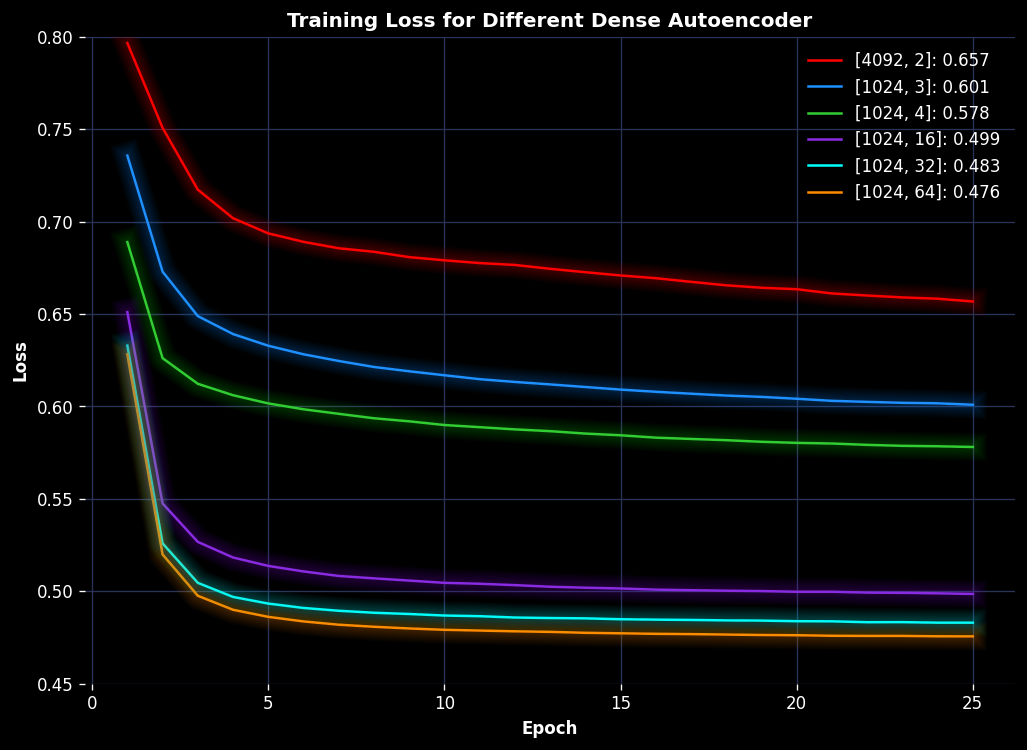

In [22]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.45, 0.8])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=dict(list(loss_results.items())[-6:]),
          config_dict=config,
          title=f'Training Loss for Different Dense Autoencoder',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.1_image_7.png');

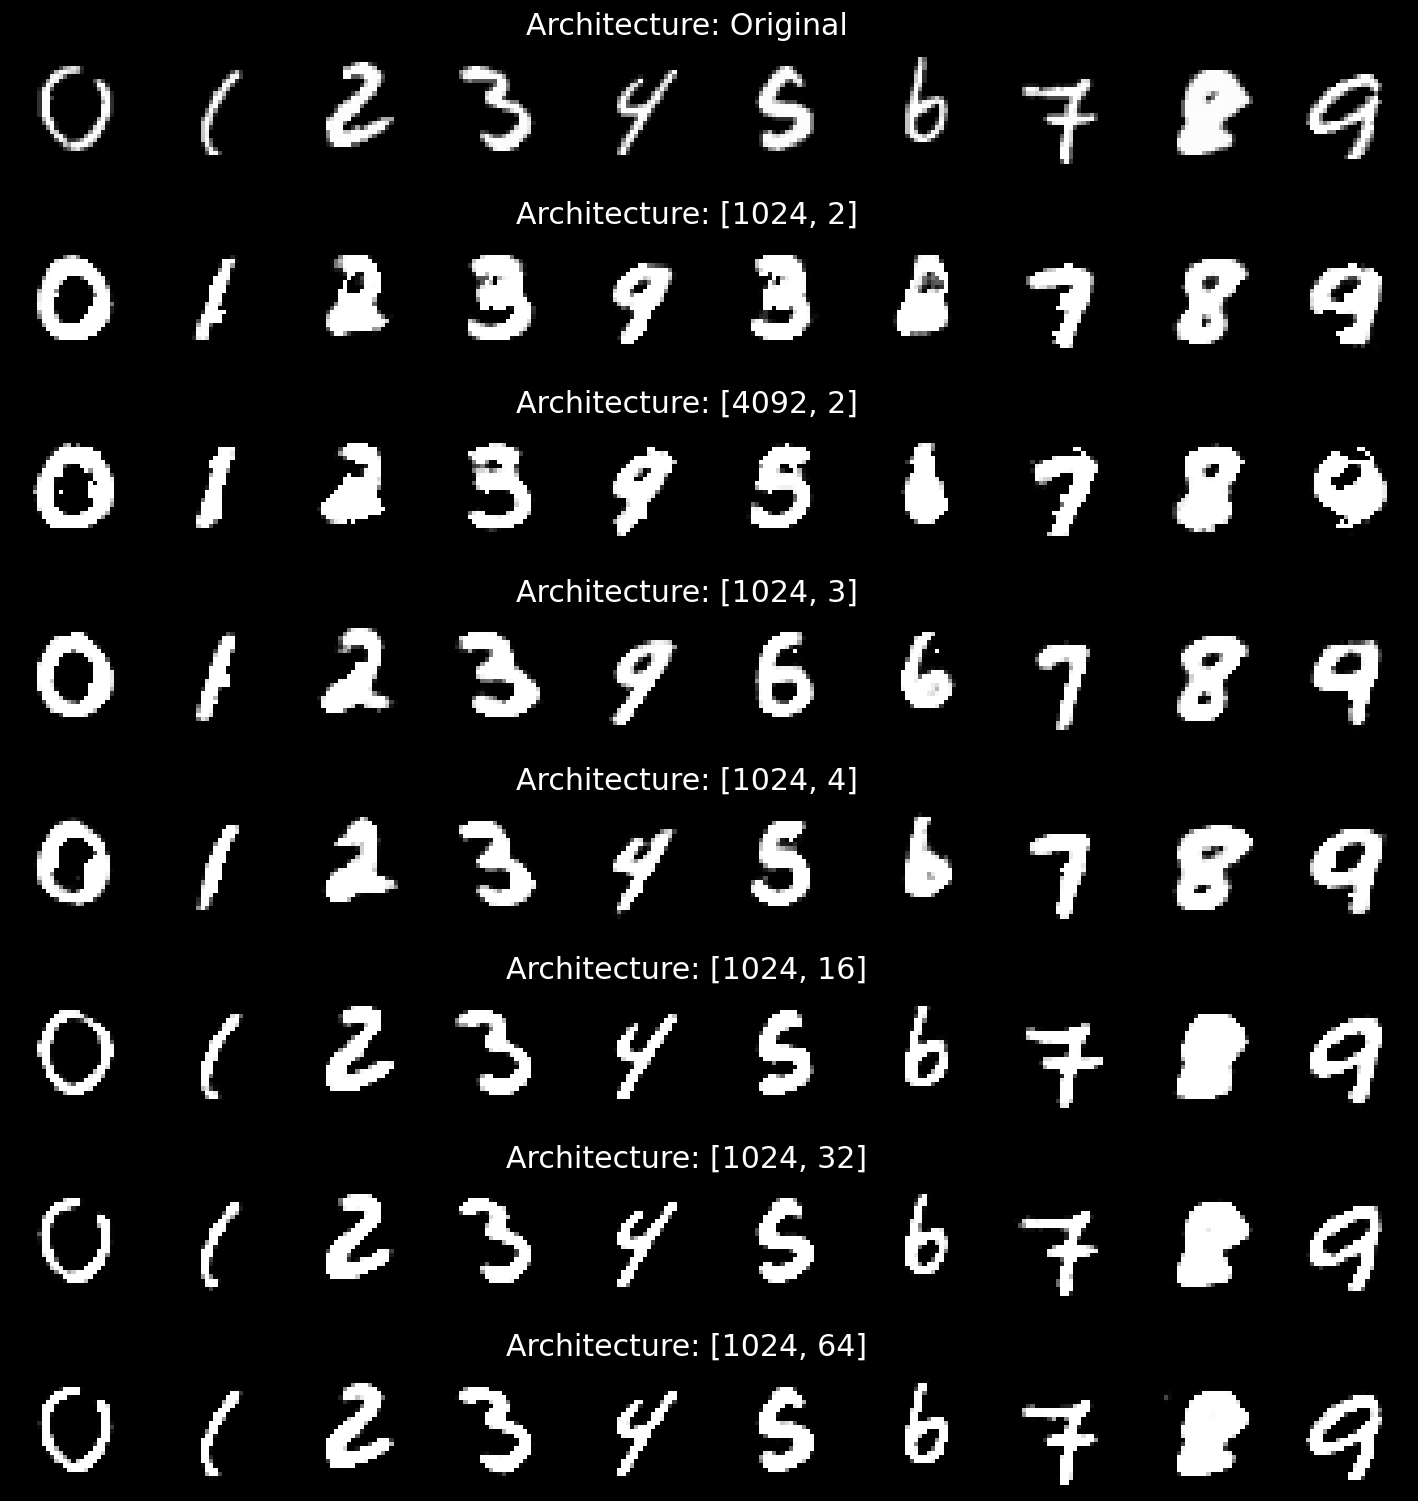

In [23]:
figure, _ = compare_generated_to_original_mnist(
    dict(list(trained_models.items())[-7:]), mnist_test)
figure.savefig('./images/9.1_image_8.png');

We can see that more dimensions massively improves performance of the net. It is important to keep in mind that original data has 784 dimensions, so 128 starts to make the network redundant.

Let's now visualize it using PCA, t-SNE or U-MAP

In [24]:
subset_size = 5000
n_dim_points, n_dim_labels = get_latent_space_points(
    trained_models['[1024, 64]'].encoder, mnist_test)
n_dim_labels = np.array(n_dim_labels)
random_subset = np.random.randint(0, len(mnist_test)-1, size=subset_size)
n_dim_points = np.swapaxes(n_dim_points, 1, 0)
n_dim_points = n_dim_points[random_subset]
n_dim_labels = n_dim_labels[random_subset]
n_dim_points.shape

100%|██████████| 40/40 [00:01<00:00, 24.38it/s]


(5000, 64)

In [25]:
projections = {}
for n_dim in [2, 3]:
    print(f'Dimensions: {n_dim}')
    start = time()
    pca = PCA(n_components=n_dim)
    projections[f'PCA_{n_dim}d'] = pca.fit_transform(n_dim_points)
    print(f'PCA: {(time() - start) * 1000:.2f} miliseconds')

    start = time()
    tsne = TSNE(n_components=n_dim, perplexity=30, random_state=42)
    projections[f'TSNE_{n_dim}d'] = tsne.fit_transform(n_dim_points)
    print(f'TSNE: {(time() - start) * 1000:.2f} miliseconds')

    start = time()
    umap_ = umap.UMAP(n_components=n_dim, n_neighbors=100)
    projections[f'UMAP_{n_dim}d'] = umap_.fit_transform(n_dim_points)
    print(f'UMAP: {(time() - start) * 1000:.2f} miliseconds')

Dimensions: 2
PCA: 25.50 miliseconds
TSNE: 15632.50 miliseconds
UMAP: 21046.72 miliseconds
Dimensions: 3
PCA: 11.00 miliseconds
TSNE: 37030.50 miliseconds
UMAP: 3860.50 miliseconds


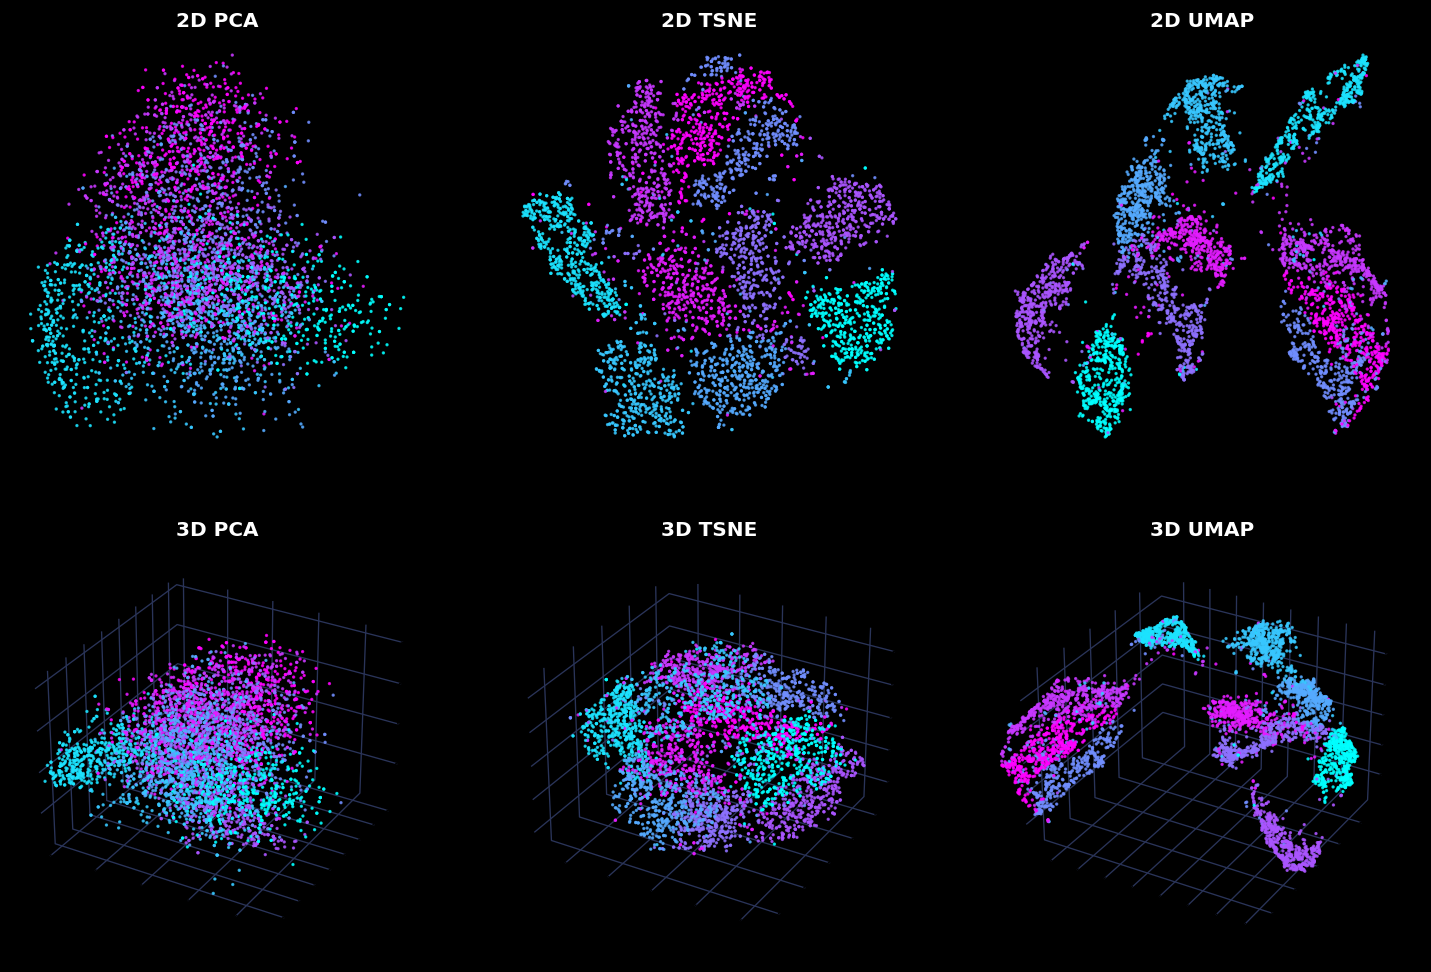

In [26]:
s, alpha, zoom = 1, 0.8, 0.85
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
for row, n_dim in enumerate([2, 3]):
    for col, mapping in enumerate(['PCA', 'TSNE', 'UMAP']):
        coords = np.swapaxes(projections[f'{mapping}_{n_dim}d'], 1, 0)
        axes[row, col].axis(False)
        if n_dim == 2:
            axes[row, col].scatter(*coords, c=n_dim_labels, s=s, alpha=alpha)
        else:
            axes[row, col] = figure.add_subplot(2, 3, col + 4, projection='3d')
            axes[row, col].scatter(*coords, c=n_dim_labels, s=s, alpha=alpha)
            for axis in [axes[row, col].xaxis, axes[row, col].yaxis, axes[row, col].zaxis]:
                axis.set_tick_params(which='major', color='black')
            axes[row, col].set_xticklabels([])
            axes[row, col].set_yticklabels([])
            axes[row, col].set_zticklabels([])
            axes[row, col].set_xlim(zoom_limits(coords[0], zoom_factor=zoom))
            axes[row, col].set_ylim(zoom_limits(coords[1], zoom_factor=zoom))
            axes[row, col].set_zlim(zoom_limits(coords[2], zoom_factor=zoom))
        
        axes[row, col].set(title=f'{n_dim}D {mapping}')
figure.savefig('./images/9.1_image_9.png')

We can see that TSNE makes the best projections, but it takes a lot of time to compute